In [1]:
from brian2 import *
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp

%matplotlib notebook

from importlib import reload
reload(dp);

In [2]:
def generate_periodic_spike_times(rate, start_time, stop_time):
    ###unitless but do it in seconds to make it easy
    duration = stop_time - start_time
    num_spikes = np.floor(duration * rate)
    true_duration = num_spikes / rate
    spike_times = np.linspace(start_time, start_time + true_duration, num_spikes)
    return spike_times

def connect_neuron_groups(pre_group, post_group,
                          conductance_name = 'e',
                          p = 1, 
                          w_mu = 1 * nS, 
                          w_sigma = 0.1 * nS):
    on_pre_equation = 'g_' + conductance_name + '_post += w'
    S = Synapses(pre_group, post_group,model = 'w : siemens',
                             on_pre = on_pre_equation)
    S.connect(p = p)
    S.w =  w_mu + w_sigma * randn(S.w.shape[0])
    S.w['w < 0 * nS'] = 0 * nS
    return S

class neuron_group_constructor():
        
    def __init__(self):
        self.params = {}
    
    def select_cell_type(self, cell_type):
        self.params = dp.get_neuron_params(cell_type)
        return self
    
    def return_ta(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        I_ex_array = np.tile(I_ex, (tb.shape[0],1))
        self.I_ex = TimedArray(I_ex_array,sim_dt)
        return I_ex_array
    
    def initialize_external_current_array(self):
        N = self.params['N']
        tb = np.arange(0,duration,sim_dt)
        I_ex_mu = self.params['intrinsics']['I_ex_mu']
        I_ex_sigma = self.params['intrinsics']['I_ex_sigma']
        I_ex = (I_ex_mu + I_ex_sigma * randn(N))
        self.I_ex = np.tile(I_ex, (tb.shape[0],1)) 
        return self

    def generate_neuron_group(self, initialize = True):
        
        N = self.params['N']
        self.initialize_external_current_array()
        
        # create neuron group and add params to namespace
        NG = NeuronGroup(N, model=self.params['model_eq'],
                     threshold=self.params['threshold_eq'],
                     reset=self.params['reset_eq'],
                     refractory=self.params['refractory_eq'],
                     method = 'euler')

        for key, value in self.params['intrinsics'].items():
            NG.namespace[key] = value
  
        # constant parameters that vary between neurons in this group
        g_l_mu = self.params['intrinsics']['g_l_mu']
        g_l_sigma = self.params['intrinsics']['g_l_sigma']
        NG.g_l = (g_l_mu + g_l_sigma * randn(N))
        
        if initialize:
            NG.g_i = '0 * nS'
            NG.g_e = '0 * nS'
            NG.v = self.params['intrinsics']['E_l']   
            if self.params['dynamics'] == 'adex':
                 NG.u = '0 * pA'
        
        return NG, self.params.copy(), self.I_ex
    
    ## projection neurons
    

        
    
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,duration,sim_dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *sim_dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind
    
class afferent_group():
    
    def __init__(self):
        self.params = {}
        self.time_bins = np.arange(0,duration,sim_dt)
        self.psth = np.zeros(self.time_bins.shape)
        
    def select_cell_type(self, cell_type):
        self.params = dp.get_afferent_params(cell_type)
        return self
        
    def add_stim(self, stim_type, start_time,**kwargs):
        
        if stim_type == 'electrical':
            sigma = self.params['stim_electrical_sigma']
            N = self.params['N']
            rates = self.params['stim_electrical_rates']
            if not isinstance(rates, (list, tuple, np.ndarray)):
                rates = np.ones(N)*rates
            
            stim_response, time_bins = gaussian_psth(start_time + self.params['delay'], sigma)
            self.psth += stim_response
            self.spikes, self.ind = generate_population_spikes(self.psth,rates)
            
    def add_spikes(self, indices,spikes):
        
            self.spikes = spikes 
            self.ind = indices
        
    def generate_afferent_group(self):
        return SpikeGeneratorGroup(self.params['N'], self.ind, self.spikes), self.params.copy()
    
    
def initialize_I_ex(NG, I_ex):
    NG.namespace['I_ex'] = TimedArray(I_ex,sim_dt)
    
def add_step(I_ex, start, stop, amplitude):
    tb = np.arange(0,duration,sim_dt)
    window = (tb > start) & (tb < stop)
    I_ex[window,:] = amplitude
    return I_ex       

In [37]:
import csv
thing = []
with open('C_to_PrP_EPSP_.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        thing.append(row)
        
x = []
y = []
for i in thing[1:]:
    x.append(float(i[0]))
    y.append(float(i[1]))
    
x = np.array(x)
y = np.array(y)
x -= x[0]
y -= y[0]  
y -= 70


In [38]:
y

array([-70.        , -70.        , -70.        , -70.        ,
       -69.55541509, -69.55541509, -69.55541509, -69.55541509,
       -69.33312263, -67.99936789, -65.33185841, -59.55225453,
       -56.44016013, -57.10703751, -50.21597134, -49.54909397,
       -50.66055626, -51.994311  , -52.66118837, -53.77265065,
       -54.88411294, -56.55130636, -57.32932996, -58.21849979,
       -59.10766962, -59.99683944, -61.33059418, -61.99747155,
       -63.3312263 , -63.77581121, -64.22039612, -64.88727349,
       -65.33185841, -66.44332069, -66.8879056 , -67.11019806,
       -67.33249052, -67.77707543, -68.22166035, -68.66624526,
       -68.66624526, -68.88853772, -69.11083017, -69.11083017,
       -69.11083017, -69.11083017, -69.11083017, -69.11083017,
       -69.11083017, -69.11083017, -69.55541509, -69.33312263,
       -69.55541509, -69.33312263, -69.55541509])

In [39]:
from scipy.interpolate import interp1d
interp = interp1d(x,y)

In [72]:
################################################################################
# Model parameters
################################################################################
### General parameters
duration = x[-1]*ms  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
defaultclock.dt = sim_dt

In [85]:
tb = np.arange(0,duration,sim_dt)
train_v = interp(tb/ms) * mV
train_v = train_v/volt

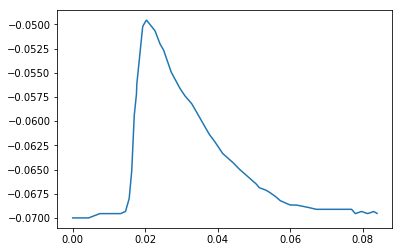

In [86]:
plt.plot(tb,train_v)

In [61]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [62]:
net.run(duration, report = 'text',profile = True)

Starting simulation at t=0. s for a duration of 84.09436671 ms
0.08409436671023592 (100%) simulated in < 1s


(5, 20)

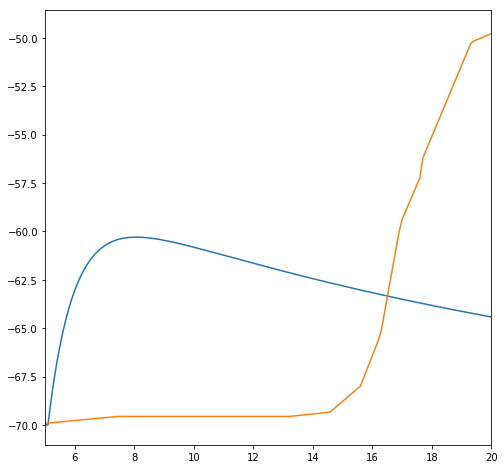

In [87]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [91]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

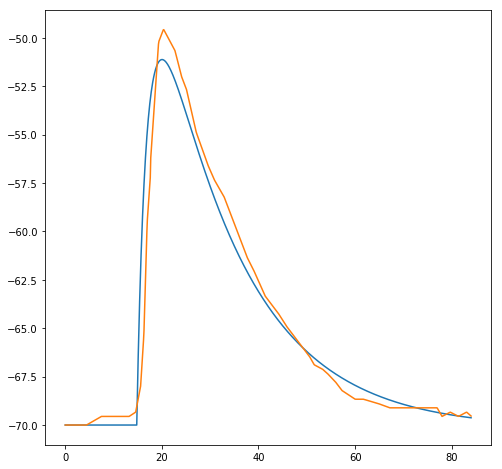

In [92]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [88]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

NameError: name 'res' is not defined

In [89]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

[28.36939959 13.09645344  2.98204282  1.28745195]
[28.36939959 13.09645344  2.98204282  1.28745195] 0.023238378170734472
[21.60010462 14.63374073  0.94936697  7.83494802]
[21.60010462 14.63374073  0.94936697  7.83494802] 0.08076994079824373
[28.58140561 16.39454876  3.15187031  4.10112954]
[28.58140561 16.39454876  3.15187031  4.10112954] 0.011227906244585271
[ 1.06153213 15.59823933  1.75928295  6.67064746]
[ 1.06153213 15.59823933  1.75928295  6.67064746] 0.01837634655625699
[11.35430604 18.92889751  1.91085674  5.93567748]
[11.35430604 18.92889751  1.91085674  5.93567748] 0.02205604124116277
[ 7.11993542 19.20862242  2.54803959  9.1091377 ]
[ 7.11993542 19.20862242  2.54803959  9.1091377 ] 0.05684098641913512
[11.94665862 19.53571222  2.2717868   4.84834716]
[11.94665862 19.53571222  2.2717868   4.84834716] 0.0417808537889543
[27.32007503 17.52259502  1.50756604  0.10326599]
[27.32007503 17.52259502  1.50756604  0.10326599] 0.03168009953860521
[17.47270748 15.89894646  3.67017388  6

[ 7.86999617 16.42105495  1.28456886  6.4117588 ] 0.06425238287746977
[ 1.46761929 17.41708609  2.12384596  5.40689771]
[ 1.46761929 17.41708609  2.12384596  5.40689771] 0.02192645166284115
[ 6.36746704 15.63689089  3.87988704  6.81933499]
[ 6.36746704 15.63689089  3.87988704  6.81933499] 0.006884980951980962
[14.89321319 13.34090896  2.82339441  4.98688032]
[14.89321319 13.34090896  2.82339441  4.98688032] 0.01446437794403902
[ 9.48152382 14.92890127  1.13666355  3.83926246]
[ 9.48152382 14.92890127  1.13666355  3.83926246] 0.013788190444538048
[27.6689157  14.84315633  4.87962325  6.9061554 ]
[27.6689157  14.84315633  4.87962325  6.9061554 ] 0.030698332897989303
[ 1.61534973 15.22626407  4.6272398   9.27036785]
[ 1.61534973 15.22626407  4.6272398   9.27036785] 0.019685315155426524
[13.44723384 16.05461826  4.08778154  0.54970393]
[13.44723384 16.05461826  4.08778154  0.54970393] 0.026306087615620456
[13.6706364  18.56379348  3.10090306  8.10328091]
[13.6706364  18.56379348  3.1009030

[ 3.90294013 18.56379348  3.13261007  7.89691857] 0.017125130648071543
[ 2.94788325 15.30109829  3.98502398  9.76337089]
[ 2.94788325 15.30109829  3.98502398  9.76337089] 0.0022556725271812455
[ 9.12382631 13.3171446   2.17126982  7.24304938]
[ 9.12382631 13.3171446   2.17126982  7.24304938] 0.05222838971458495
[16.49741085 14.56443319  1.94531269  1.479074  ]
[16.49741085 14.56443319  1.94531269  1.479074  ] 0.013055986473042352
[ 2.93648458 13.08713465  2.46496313  8.72821956]
[ 2.93648458 13.08713465  2.46496313  8.72821956] 0.005855810042759653
[18.50846722 14.20467198  3.78957904  9.70701869]
[18.50846722 14.20467198  3.78957904  9.70701869] 0.05256636220005351
[ 1.85857985 15.29646381  4.37486599  8.99241747]
[ 1.85857985 15.29646381  4.37486599  8.99241747] 0.010936677165337073
[18.73171815 13.69460599  4.92518532  3.52318948]
[18.73171815 13.69460599  4.92518532  3.52318948] 0.013578345195618874
[19.48512744 16.1361235   2.39427311  3.53462141]
[19.48512744 16.1361235   2.39427

[ 6.8780662  15.81412806  4.79771986  6.55914183] 0.003944025456101306
[17.76719842 16.07390506  3.88752519  7.20946285]
[17.76719842 16.07390506  3.88752519  7.20946285] 0.022391087614451334
[ 1.22462251 14.65967985  3.80309966  7.92040871]
[ 1.22462251 14.65967985  3.80309966  7.92040871] 0.02408324923153786
[29.46062246 16.09821849  3.15495685  9.40091529]
[29.46062246 16.09821849  3.15495685  9.40091529] 0.05184552076508764
[ 3.00875539 16.22309029  3.38859658  5.7690768 ]
[ 3.00875539 16.22309029  3.38859658  5.7690768 ] 0.005640397434928128
[ 3.42523843 17.49315413  4.94998838  6.68882236]
[ 3.42523843 17.49315413  4.94998838  6.68882236] 0.008020138420001977
[16.32432131 14.15885731  1.44057167  7.37394768]
[16.32432131 14.15885731  1.44057167  7.37394768] 0.0975757505824395
[ 6.97154055 14.67463867  4.98589746  4.95225935]
[ 6.97154055 14.67463867  4.98589746  4.95225935] 0.003631557449387049
[ 8.06427502 13.00467031  2.82575196  9.9974243 ]
[ 8.06427502 13.00467031  2.82575196

[ 8.06427502 16.83633823  2.91920474  8.83052315] 0.04040809239127938
[27.45493612 19.82294711  2.91860681  2.5344886 ]
[27.45493612 19.82294711  2.91860681  2.5344886 ] 0.014862236715423808
[ 9.96577873 18.05541414  2.64213933  9.86400772]
[ 9.96577873 18.05541414  2.64213933  9.86400772] 0.06582093088251
[ 7.70123694 13.30638385  2.80014502  9.72671192]
[ 7.70123694 13.30638385  2.80014502  9.72671192] 0.04770731620900259
[ 6.26311084 14.94093976  3.16812769  9.83431569]
[ 6.26311084 14.94093976  3.16812769  9.83431569] 0.015413554183248163
[10.55456669 14.5281237   4.80391843  4.77963697]
[10.55456669 14.5281237   4.80391843  4.77963697] 0.012929900463723828
[ 3.42923927 16.87349979  4.53083272  6.05839137]
[ 3.42923927 16.87349979  4.53083272  6.05839137] 0.006996679959370552
[ 6.54590764 15.5971133   4.7791978   1.01472134]
[ 6.54590764 15.5971133   4.7791978   1.01472134] 0.03142983902683448
[19.2814994  14.87042811  4.20234041  7.86765153]
[19.2814994  14.87042811  4.20234041  7

[ 2.19978052 15.74936793  2.21476787  8.56975597] 0.007965863155100915
[ 2.70069979 17.56987741  3.40755272  0.61076024]
[ 2.70069979 17.56987741  3.40755272  0.61076024] 0.04406469162647387
[ 1.07312101 17.02192853  1.39516066  8.54219934]
[ 1.07312101 17.02192853  1.39516066  8.54219934] 0.02005548628035944
[21.04614533 15.80087161  4.88340259  2.3152077 ]
[21.04614533 15.80087161  4.88340259  2.3152077 ] 0.010849794771462902
[ 2.02964245 13.61347407  2.92306044  6.31268997]
[ 2.02964245 13.61347407  2.92306044  6.31268997] 0.010864699655966292
[10.21954065 16.83277031  4.44825051  8.28681788]
[10.21954065 16.83277031  4.44825051  8.28681788] 0.02518824199325883
[ 7.32330771 14.85404393  3.69542874  5.80175834]
[ 7.32330771 14.85404393  3.69542874  5.80175834] 0.009772546140609358
[ 3.24288353 14.57067673  1.28706874  7.30316808]
[ 3.24288353 14.57067673  1.28706874  7.30316808] 0.03501550218463188
[ 5.58939004 16.46306052  0.98715101  4.42158132]
[ 5.58939004 16.46306052  0.98715101

[ 0.29086214 14.65934633  2.8144167   4.42158132] 0.041165748614361584
[13.28558458 15.81928173  2.50853235  5.70024717]
[13.28558458 15.81928173  2.50853235  5.70024717] 0.01366508917722519
[ 2.1329566  14.69648251  3.55632474  7.43597025]
[ 2.1329566  14.69648251  3.55632474  7.43597025] 0.008672918877387676
[ 4.89676431 16.04602043  4.66181221  4.96524191]
[ 4.89676431 16.04602043  4.66181221  4.96524191] 0.003205377978782337
[17.69841288 14.39092306  3.55639185  2.97214784]
[17.69841288 14.39092306  3.55639185  2.97214784] 0.009064749672357144
[ 4.1294198  14.35110633  1.04960822  7.7227439 ]
[ 4.1294198  14.35110633  1.04960822  7.7227439 ] 0.11045122031910395
[ 1.6955367  13.5623306   3.39130224  5.88297319]
[ 1.6955367  13.5623306   3.39130224  5.88297319] 0.019134526601042066
[27.10800901 15.18185968  3.39313153  7.35647455]
[27.10800901 15.18185968  3.39313153  7.35647455] 0.03227030444342008
[ 1.63831357 17.24823859  4.47656668  7.5846885 ]
[ 1.63831357 17.24823859  4.4765666

[ 3.74540689 15.95988238  2.25789163  2.63795921] 0.009841564342808397
[ 6.68109559 14.88741053  0.78713094  6.82126472]
[ 6.68109559 14.88741053  0.78713094  6.82126472] 0.09549127193582983
[ 3.6657767  16.40449541  4.3236595   6.22741552]
[ 3.6657767  16.40449541  4.3236595   6.22741552] 0.004410331325418277
[ 3.20516071 14.79145629  3.89352448  8.69730958]
[ 3.20516071 14.79145629  3.89352448  8.69730958] 0.0015874423600432419
[ 1.12727401 14.38692821  4.66806229  7.71989378]
[ 1.12727401 14.38692821  4.66806229  7.71989378] 0.02791082432162119
[ 8.80535721 14.85647562  4.97293892  1.82722175]
[ 8.80535721 14.85647562  4.97293892  1.82722175] 0.016894864548539897
[14.42213993 16.91525876  3.53841543  4.68983681]
[14.42213993 16.91525876  3.53841543  4.68983681] 0.017052805208608423
[ 5.85118969 16.01454392  4.98436127  8.90305112]
[ 5.85118969 16.01454392  4.98436127  8.90305112] 0.006001886652065832
[ 5.05633707 15.87522398  0.90693344  7.03189305]
[ 5.05633707 15.87522398  0.90693

clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
clang: warning: libstdc++ is deprecated; move to libc++ with a m

KeyboardInterrupt: 

In [144]:
train_v = states.v_[0]

In [195]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [196]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

[39.46008095  3.90341956  3.92193719]
pep1 i_gal
[32.15579689  2.85689581  1.64165258]
pep1 i_gal
[17.13740054  6.78661598  2.68196795]
pep1 i_gal
[37.8842714   0.92607656  2.17223091]
pep1 i_gal
[2.35571613 5.07840716 5.82857633]
pep1 i_gal
[25.64616103  9.68019254  4.38265211]
pep1 i_gal
[41.48144198  7.38591793  4.96942638]
pep1 i_gal
[44.21002975  5.5179885   3.16967905]
pep1 i_gal
[0.44676266 9.06111771 6.9149556 ]
pep1 i_gal
[23.16383506  2.00813905  7.81213403]
pep1 i_gal
[27.48391743  2.27982981  6.69438437]
pep1 i_gal
[37.14467729  4.35416717  0.19493183]
pep1 i_gal
[29.15939422  7.10395007  1.99707503]
pep1 i_gal
[18.31086132  1.00767123  6.20722402]
pep1 i_gal
[11.30343614  9.3229713   3.78596792]
pep1 i_gal
[7.98380223 2.44410872 6.34760984]
pep1 i_gal
[15.88291356  7.59072933  7.65468697]
pep1 i_gal
[4.32841425 8.71509522 0.78286673]
pep1 i_gal
[30.59737923  9.79059751  4.17423149]
pep1 i_gal
[33.56052373  0.35160298  5.20807361]
pep1 i_gal
[42.63554726  2.53416732  9.6241

KeyboardInterrupt: 

In [179]:
res

     fun: 1.7528829943492521e-06
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1005
     nit: 30
 success: False
       x: array([10.13469542,  5.08155952])

<IPython.core.display.Javascript object>


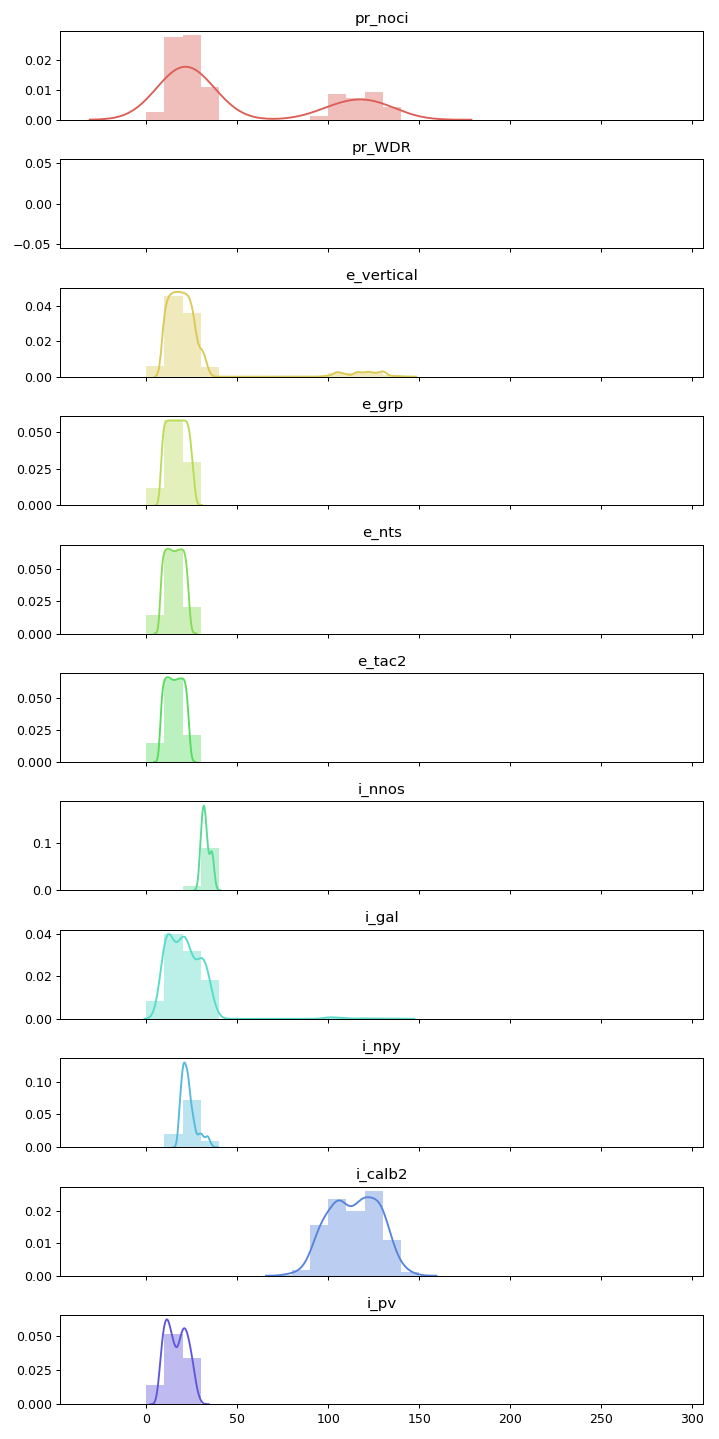

In [93]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [107]:
reversed(ax.get_ylim())

<IPython.core.display.Javascript object>


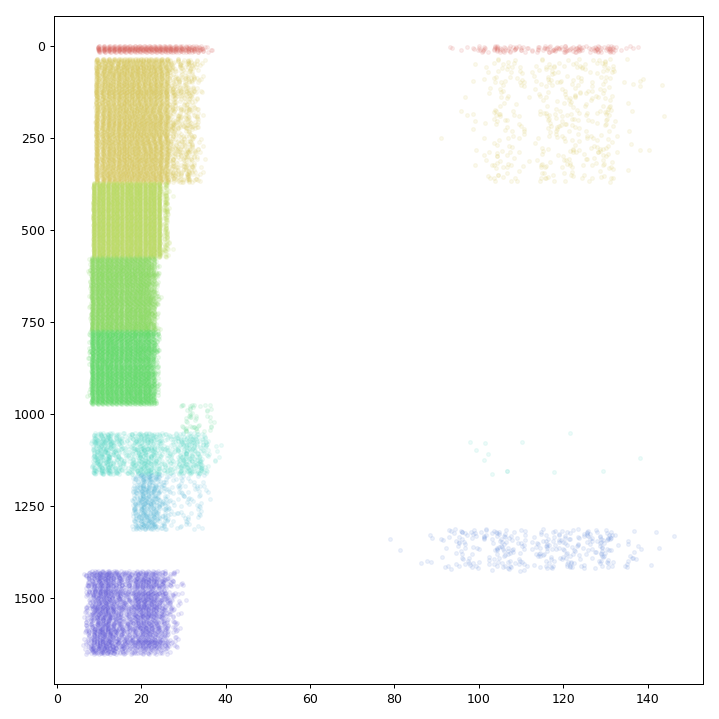

(1735.65, -82.65)

In [108]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.1);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

<IPython.core.display.Javascript object>


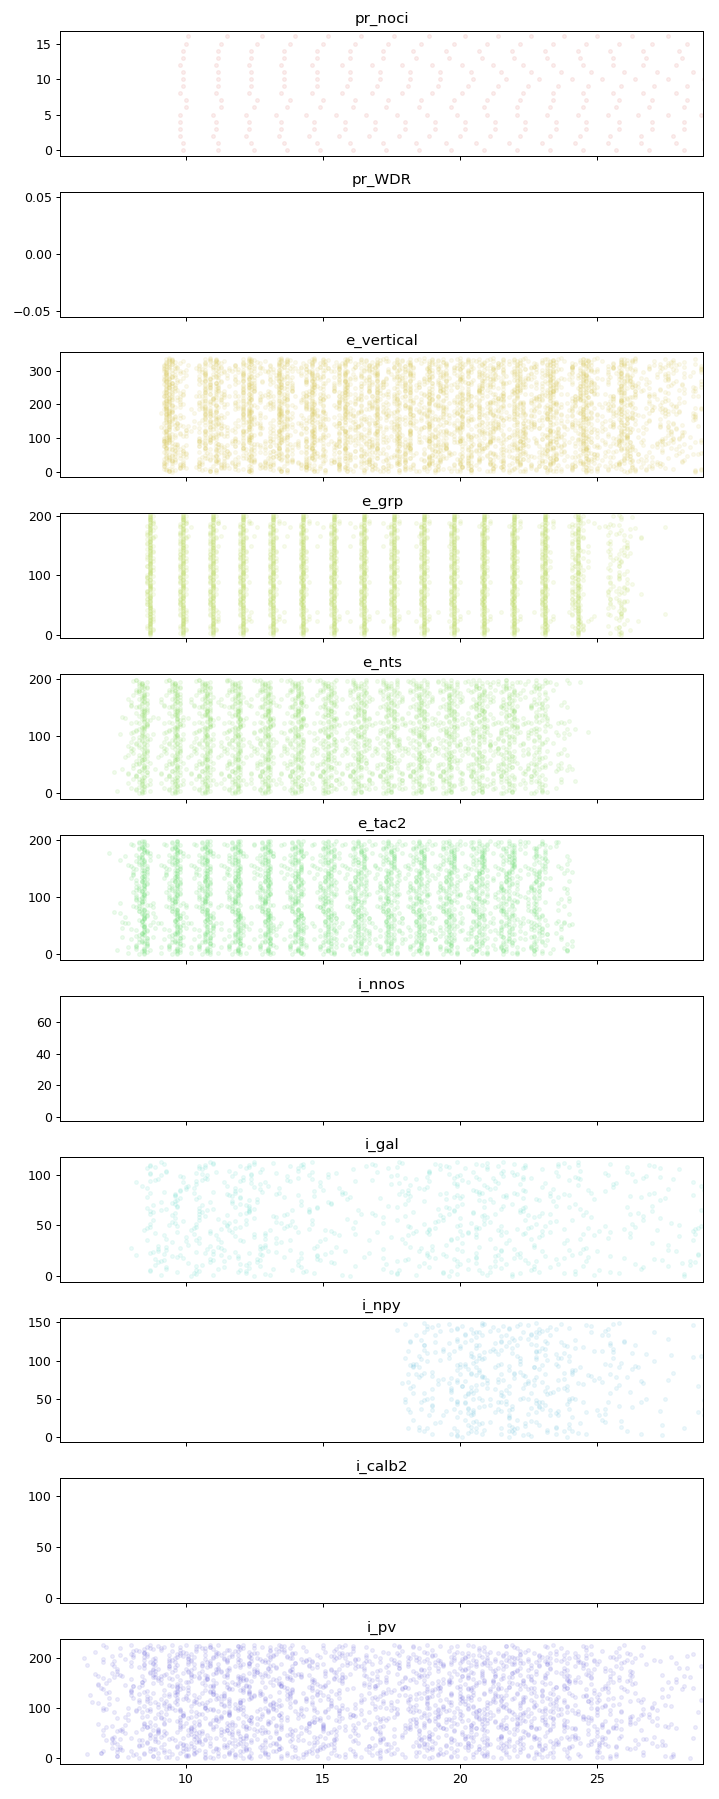

In [110]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [80]:
state_mon.v_.shape

(17, 6000)

In [81]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

<IPython.core.display.Javascript object>


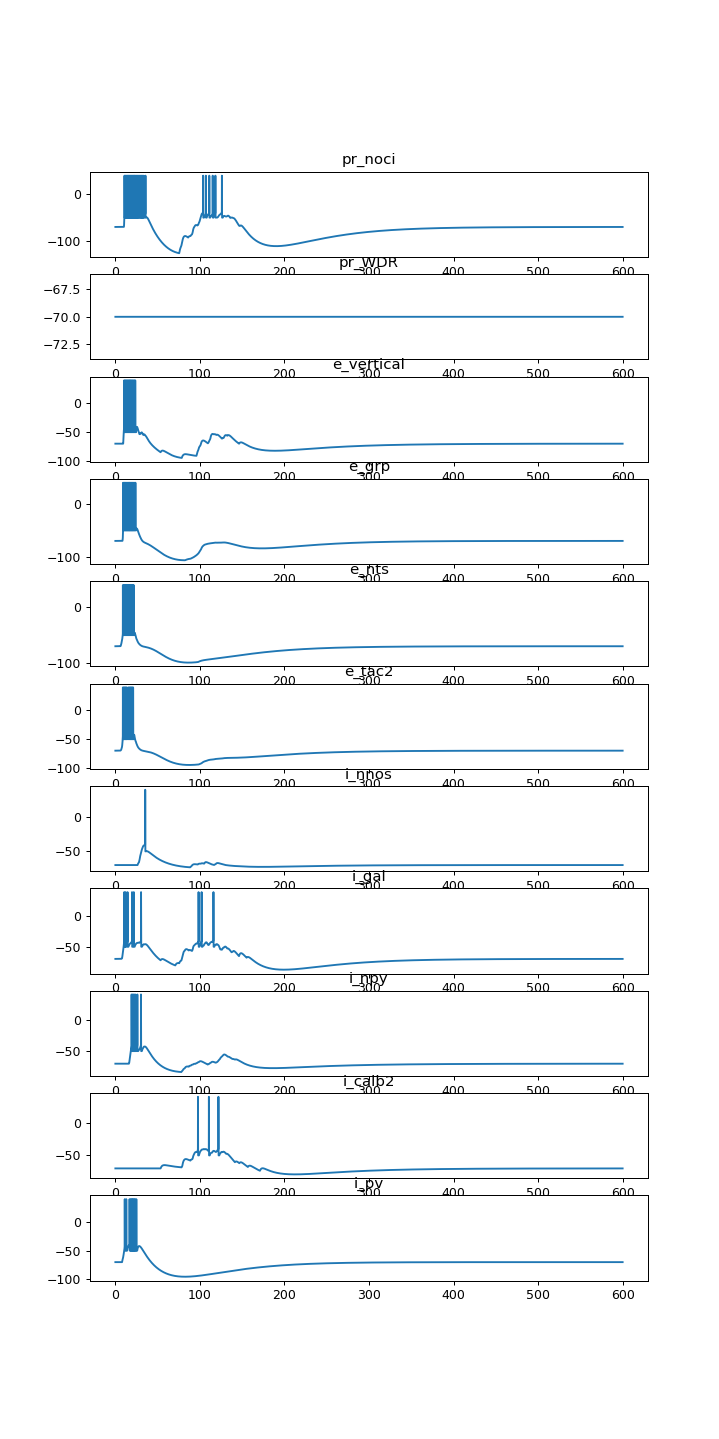

In [82]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)